In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from google.colab import files

# Upload the dataset file
uploaded = files.upload()

# Read the Excel file
df = pd.read_excel(list(uploaded.keys())[0])

# Preview data
df.head()


Saving Online Retail.xlsx to Online Retail.xlsx


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df.dropna(subset=['CustomerID'],inplace=True)

#keeping only positive values
df=df[df['Quantity']>0]

#creating new column for total price
df['Total Price']=df['Quantity']*df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total Price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [5]:
#define latest date for recency calculation
latest_date=df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm= df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,     #recency
    'InvoiceNo': 'count',                                      #frequency
    'Total Price': 'sum'                                       #monetary
})

rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'Total Price': 'Monetary'
}, inplace=True)


rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40


In [6]:
# Function to assign scores dynamically
def assign_scores(series, reverse=False):
    bins = pd.qcut(series, 4, duplicates='drop')
    num_bins = bins.cat.categories.size
    labels = list(range(num_bins, 0, -1)) if reverse else list(range(1, num_bins + 1))
    return pd.qcut(series, num_bins, labels=labels, duplicates='drop').astype(int)

# Assign scores
rfm['R_Score'] = assign_scores(rfm['Recency'], reverse=True)
rfm['F_Score'] = assign_scores(rfm['Frequency'])
rfm['M_Score'] = assign_scores(rfm['Monetary'])

# Total RFM Score
rfm['RFM_Score'] = rfm['R_Score'] + rfm['F_Score'] + rfm['M_Score']

rfm.head()


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
CustomerID,,,,,,,
12346.0,326,1,77183.60,1,1,4,6
12347.0,2,182,4310.00,4,4,4,12
12348.0,75,31,1797.24,2,2,4,8
12349.0,19,73,1757.55,3,3,4,10
12350.0,310,17,334.40,1,1,2,4


In [7]:
# Segmentation function
def segment(score):
    if score >= 9:
        return 'Best Customers'
    elif score >= 8:
        return 'Loyal Customers'
    elif score >= 5:
        return 'Potential Loyalist'
    else:
        return 'Needs Attention'

# Apply segmentation
rfm['Segment'] = rfm['RFM_Score'].apply(segment)

rfm.head()


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,4,6,Potential Loyalist
12347.0,2,182,4310.00,4,4,4,12,Best Customers
12348.0,75,31,1797.24,2,2,4,8,Loyal Customers
12349.0,19,73,1757.55,3,3,4,10,Best Customers
12350.0,310,17,334.40,1,1,2,4,Needs Attention


/tmp/ipython-input-571218551.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


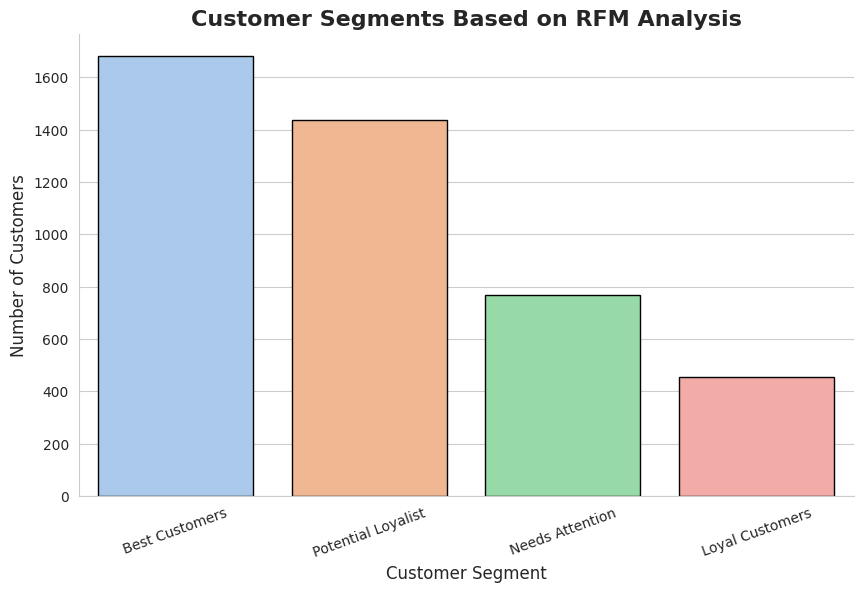

In [11]:
# Improved visualization with style changes
plt.figure(figsize=(10, 6))

# Choose a clean style
sns.set_style("whitegrid")

# Use a pastel palette
sns.countplot(
    data=rfm,
    x='Segment',
    order=rfm['Segment'].value_counts().index,
    palette='pastel',
    edgecolor='black'
)


# Titles and labels
plt.title('Customer Segments Based on RFM Analysis', fontsize=16, fontweight='bold')
plt.xlabel('Customer Segment', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)

# Rotate x labels for readability
plt.xticks(rotation=20)

# Remove top/right borders
sns.despine()

plt.show()


In [9]:
# Save to CSV
rfm.to_csv('RFM_Segmentation.csv', index=False)

# Download the file
from google.colab import files
files.download('RFM_Segmentation.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>